In [1]:
from fspb.config import BLD_APPLICATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
y_train = pd.read_pickle(BLD_APPLICATION / "y_train.pickle")
y_pred = pd.read_pickle(BLD_APPLICATION / "y_pred.pickle")

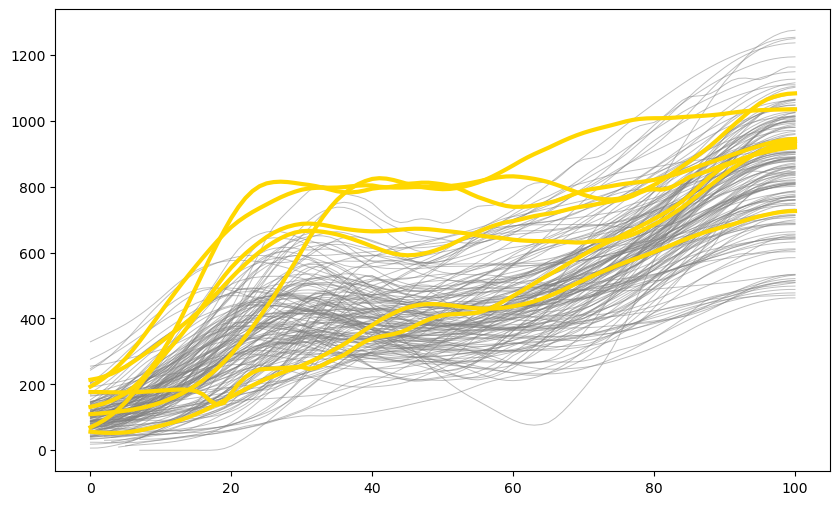

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    100 * np.linspace(0, 1, y_train.shape[1]),
    y_train.T,
    color="gray",
    linewidth=0.7,
    alpha=0.5,
)
ax.plot(100 * np.linspace(0, 1, y_pred.shape[1]), y_pred.T, color="gold", linewidth=3)

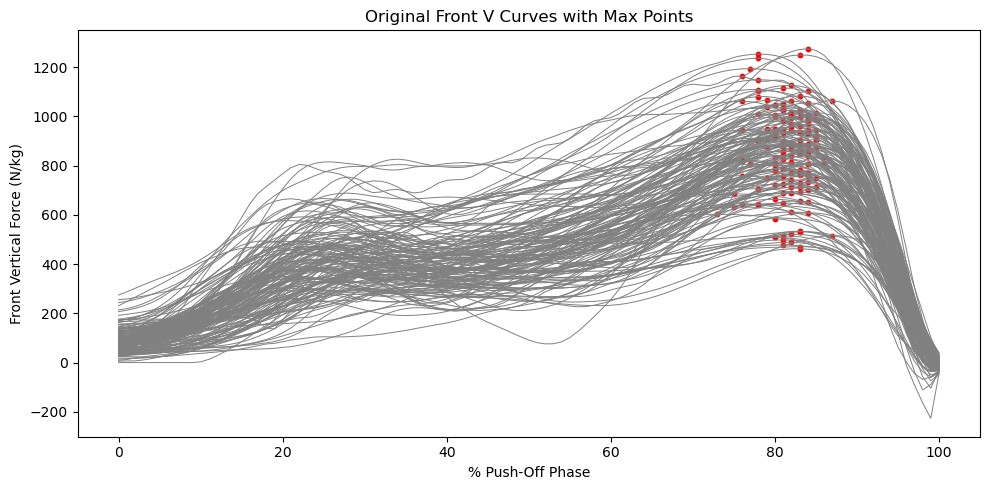

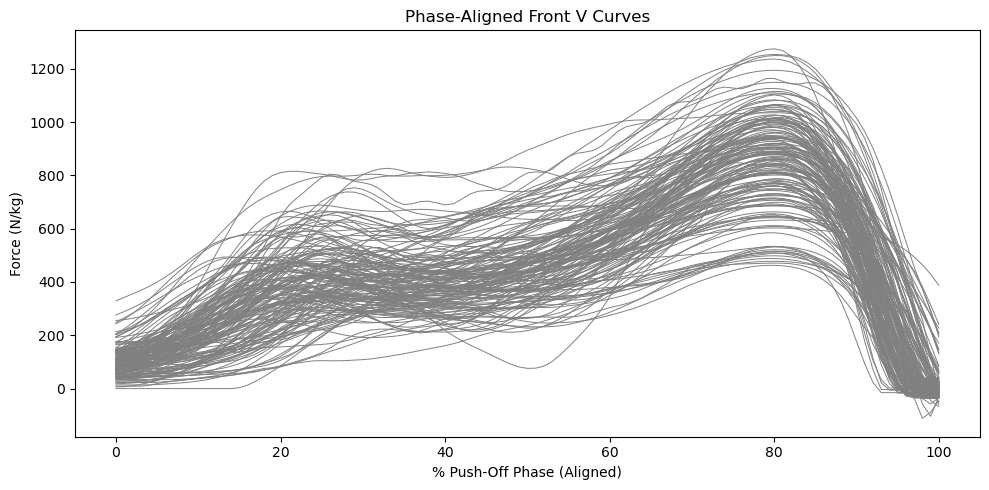

In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# y: shape (161, 101), each row is an observation, columns are time points

# 1. Find the optimal point (second peak) of all curves between int_start and int_end
# int_start and int_end are already defined (Python index, so inclusive)
# max_idx: index of max value in the interval for each observation
int_start = 70  # Python index, corresponds to 0.7 in the grid
int_end = 90  # Python index, corresponds to 0.9 in the grid
interval = np.arange(int_start, int_end + 1)
max_idx = interval[np.argmax(y[:, interval], axis=1)]
max_vals = y[np.arange(y.shape[0]), max_idx]

# 2. max_pts DataFrame
max_pts = pd.DataFrame(
    {
        "time": max_idx / 100,  # since grid is 0..1, 101 points
        "value": max_vals,
    }
)

# 3. Long form data for plotting
grid = np.linspace(0, 1, y.shape[1])
y_df_long = (
    pd.DataFrame(y, columns=range(y.shape[1]))
    .assign(Observation=lambda df: df.index)
    .melt(id_vars="Observation", var_name="t_idx", value_name="Front_V")
    .assign(t_pts=lambda df: df["t_idx"] / 100)
)

# 4. Plot original curves with max points
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(y.shape[0]):
    ax.plot(100 * grid, y[i], color="gray", linewidth=0.7)
ax.scatter(100 * max_pts["time"], max_pts["value"], color="red", s=10)
ax.set_xlabel("% Push-Off Phase")
ax.set_ylabel("Front Vertical Force (N/kg)")
ax.set_title("Original Front V Curves with Max Points")
plt.tight_layout()
plt.show()

# 5. Phase shift: align all curves so their max is at the same time point (e.g., at index 80)
target_idx = 80  # arbitrary, e.g., align all peaks to t=0.8
shifted_y = np.zeros_like(y)
for i in range(y.shape[0]):
    shift = target_idx - max_idx[i]
    shifted_y[i] = np.roll(y[i], shift)
    # Optionally, set rolled values outside valid range to np.nan or interpolate


# 6. Interpolate to get 101 sampling points for all observations (if needed)
# Here, after shifting, we may want to interpolate if rolling caused wrap-around
# For simplicity, let's set wrapped values to nan and interpolate
def shift_and_interp(row, shift):
    rolled = np.roll(row, shift)
    if shift > 0:
        rolled[:shift] = np.nan
    elif shift < 0:
        rolled[shift:] = np.nan
    # Interpolate nans
    nans, x = np.isnan(rolled), lambda z: z.nonzero()[0]
    if np.any(nans):
        rolled[nans] = np.interp(x(nans), x(~nans), rolled[~nans])
    return rolled


shifted_y_interp = np.vstack(
    [shift_and_interp(y[i], target_idx - max_idx[i]) for i in range(y.shape[0])]
)

# 7. Long format for plotting shifted curves
shifted_long = (
    pd.DataFrame(shifted_y_interp, columns=range(y.shape[1]))
    .assign(Observation=lambda df: df.index)
    .melt(id_vars="Observation", var_name="t_idx", value_name="Front_V")
    .assign(t_pts=lambda df: df["t_idx"] / 100)
)

# 8. Plot shifted curves
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(shifted_y_interp.shape[0]):
    ax.plot(100 * grid, shifted_y_interp[i], color="gray", linewidth=0.7)
ax.set_xlabel("% Push-Off Phase (Aligned)")
ax.set_ylabel("Force (N/kg)")
ax.set_title("Phase-Aligned Front V Curves")
plt.tight_layout()
plt.show()

In [63]:
import numpy as np


def find_peak_indices(y: np.ndarray, interval: tuple[int, int]) -> np.ndarray:
    """
    Find the index of the maximum value within a given interval for each curve.

    Args:
        y: Array of shape (n_samples, n_timepoints).
        interval: (start_idx, end_idx) inclusive.

    Returns:
        Array of shape (n_samples,) with the index of the max in the interval for each sample.
    """
    int_start, int_end = interval
    interval_indices = np.arange(int_start, int_end + 1)
    max_in_interval = np.argmax(y[:, interval_indices], axis=1)
    return interval_indices[max_in_interval]


def align_curves_at_peak(
    y: np.ndarray, peak_indices: np.ndarray, target_idx: int
) -> np.ndarray:
    """
    Shift each curve so its peak is at the target index.

    Args:
        y: Array of shape (n_samples, n_timepoints).
        peak_indices: Array of shape (n_samples,) with peak indices for each curve.
        target_idx: Index to align all peaks to.

    Returns:
        Shifted array of same shape as y.
    """
    n_samples, n_timepoints = y.shape
    shifted = np.full_like(y, np.nan)
    for i in range(n_samples):
        shift = target_idx - peak_indices[i]
        if shift >= 0:
            shifted[i, shift:] = y[i, : n_timepoints - shift]
        else:
            shifted[i, :shift] = y[i, -shift:]
    return shifted


def truncate_after_peak(y_aligned: np.ndarray, peak_idx: int) -> np.ndarray:
    """
    Truncate each curve after the aligned peak (keep up to and including peak).

    Args:
        y_aligned: Array of shape (n_samples, n_timepoints), aligned so all peaks at peak_idx.
        peak_idx: Index where all peaks are aligned.

    Returns:
        Truncated array of shape (n_samples, peak_idx+1).
    """
    return y_aligned[:, : peak_idx + 1]


def interpolate_curves(y: np.ndarray, n_points: int) -> np.ndarray:
    """
    Linearly interpolate each curve to n_points.

    Args:
        y: Array of shape (n_samples, n_timepoints).
        n_points: Number of points to interpolate to.

    Returns:
        Array of shape (n_samples, n_points).
    """
    n_samples, n_timepoints = y.shape
    x_old = np.linspace(0, 1, n_timepoints)
    x_new = np.linspace(0, 1, n_points)
    y_interp = np.empty((n_samples, n_points))
    for i in range(n_samples):
        y_interp[i] = np.interp(x_new, x_old, y[i])
    return y_interp


def align_and_truncate_trajectories(
    y: np.ndarray,
    interval: tuple[int, int],
    n_interp_points: int = 101,
    target_idx: int = 80,
) -> np.ndarray:
    """
    Aligns all curves so their max in the interval occurs at target_idx,
    truncates after the aligned max, and interpolates to n_interp_points.

    Args:
        y: Raw functional data, shape (n_samples, n_timepoints).
        interval: (start_idx, end_idx) for searching the max.
        n_interp_points: Number of points for interpolation.
        target_idx: Index to align all peaks to.

    Returns:
        Array of shape (n_samples, n_interp_points) with aligned, truncated, and interpolated curves.
    """
    peak_indices = find_peak_indices(y, interval)
    y_aligned = align_curves_at_peak(y, peak_indices, target_idx)
    y_trunc = truncate_after_peak(y_aligned, target_idx)
    y_interp = interpolate_curves(y_trunc, n_interp_points)
    return y_interp

In [67]:
y_aligned = align_and_truncate_trajectories(
    y, interval=(70, 90), n_interp_points=101, target_idx=80
)

In [75]:
y_aligned[-7:, :].shape

(7, 101)

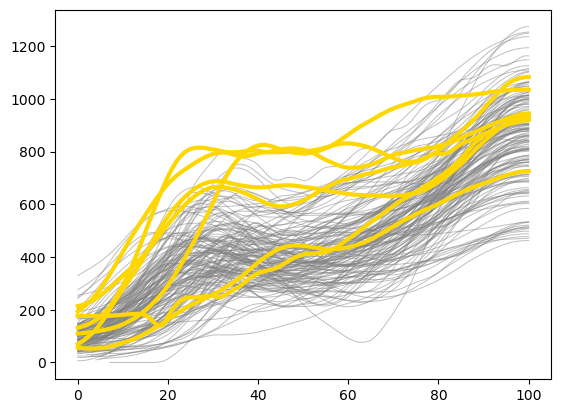

In [77]:
plt.plot(
    100 * np.linspace(0, 1, y_aligned.shape[1]),
    y_aligned.T,
    color="gray",
    linewidth=0.7,
    alpha=0.5,
)
plt.plot(
    100 * np.linspace(0, 1, y_aligned.shape[1]),
    y_aligned[-7:, :].T,
    color="gold",
    linewidth=3,
);